## Importing Data and Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np
import os
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import nltk
import pickle
from gensim.models import Word2Vec
from collections import Counter
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle

In [8]:
df = pd.read_csv('/content/questions.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [9]:
df = df.dropna(subset=['question1', 'question2'])

In [10]:
df = df[(df['question1'].str.strip() != '') & (df['question2'].str.strip() != '')]

In [11]:
df = df[(df['question1'].str.len() <= 500) & (df['question2'].str.len() <= 500)]

In [12]:
df = df[~df['question1'].str.contains(r'\d') &  ~df['question2'].str.contains(r'\d')]

In [13]:
df = df[df['question1'].apply(lambda x: isinstance(x, str)) &  df['question2'].apply(lambda x: isinstance(x, str))]

## Check for Missing Values

In [14]:
df.shape

(340052, 6)

In [15]:
df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


In [16]:
df = df.dropna()

In [17]:
df.shape

(340052, 6)

## Inspecting Data Uniqueness and Distribution

In [18]:
# Check for duplicate rows
print(f"Number of duplicate rows: {df.duplicated().sum()}")

# Check the distribution of the target column `is_duplicate`
print(df['is_duplicate'].value_counts())

Number of duplicate rows: 0
is_duplicate
0    210239
1    129813
Name: count, dtype: int64


## Checking for Class Balance

In [19]:
duplicate_percentage = df['is_duplicate'].mean() * 100
print(f"Percentage of duplicate pairs: {duplicate_percentage:.2f}%")
print(f"Percentage of non-duplicate pairs: {100 - duplicate_percentage:.2f}%")

Percentage of duplicate pairs: 38.17%
Percentage of non-duplicate pairs: 61.83%


## Remove Columns

In [20]:
# Remove the 'id', 'qid1', and 'qid2' columns
df = df.drop(['id', 'qid1', 'qid2'], axis=1)

# Display the updated DataFrame
df.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1


## Text Preprocessing

In [21]:
def preprocess_text(text):
    # Check for NaN values and return an empty string or the original text
    if pd.isna(text):
        return ''

    # Lowercasing
    text = text.lower()

    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Removing numbers
    text = re.sub(r'\d+', '', text)

    # Removing special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Removing extra whitespaces
    text = ' '.join(tokens)

    return text

In [22]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [23]:
# Preprocess the questions
df['question1'] = df['question1'].apply(preprocess_text)
df['question2'] = df['question2'].apply(preprocess_text)

# Display the updated DataFrame
df[['question1', 'question2']].head()

,question1,question2
0,step step guide invest share market india,step step guide invest share market
1,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...
2,increase speed internet connection using vpn,internet speed increased hacking dns
4,one dissolve water quikly sugar salt methane c...,fish would survive salt water
5,astrology capricorn sun cap moon cap risingwha...,im triple capricorn sun moon ascendant caprico...


In [24]:
df.head()

,question1,question2,is_duplicate
0,step step guide invest share market india,step step guide invest share market,0
1,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0
2,increase speed internet connection using vpn,internet speed increased hacking dns,0
4,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0
5,astrology capricorn sun cap moon cap risingwha...,im triple capricorn sun moon ascendant caprico...,1


## Feature Engineering

In [25]:
# Word Overlap Features
def jaccard_similarity(q1, q2):
    a = set(q1.split())
    b = set(q2.split())

    if len(a) == 0 and len(b) == 0:
        return 1.0
    elif len(a) == 0 or len(b) == 0:
        return 0.0

    return len(a.intersection(b)) / len(a.union(b))

df['jaccard'] = df.apply(lambda row: jaccard_similarity(row['question1'], row['question2']), axis=1)

In [26]:
df.head()

,question1,question2,is_duplicate,jaccard
0,step step guide invest share market india,step step guide invest share market,0,0.833333
1,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0,0.222222
2,increase speed internet connection using vpn,internet speed increased hacking dns,0,0.222222
4,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,0.153846
5,astrology capricorn sun cap moon cap risingwha...,im triple capricorn sun moon ascendant caprico...,1,0.400000


In [27]:
def compute_token_features(row):
    q1 = row['question1'].split()
    q2 = row['question2'].split()

    # Convert to sets for comparison
    tokens_q1 = set(q1)
    tokens_q2 = set(q2)

    # Count common words
    cwc = len(tokens_q1.intersection(tokens_q2))

    # Count common stop words
    csc = len(tokens_q1.intersection(tokens_q2).intersection(stop_words))

    # Length of questions
    len_q1, len_q2 = len(tokens_q1), len(tokens_q2)

    # Token Features
    cwc_min = cwc / min(len_q1, len_q2) if min(len_q1, len_q2) > 0 else 0
    cwc_max = cwc / max(len_q1, len_q2) if max(len_q1, len_q2) > 0 else 0

    csc_min = csc / min(len([word for word in tokens_q1 if word in stop_words]),
                         len([word for word in tokens_q2 if word in stop_words])) if min(len([word for word in tokens_q1 if word in stop_words]),
                         len([word for word in tokens_q2 if word in stop_words])) > 0 else 0

    csc_max = csc / max(len([word for word in tokens_q1 if word in stop_words]),
                         len([word for word in tokens_q2 if word in stop_words])) if max(len([word for word in tokens_q1 if word in stop_words]),
                         len([word for word in tokens_q2 if word in stop_words])) > 0 else 0

    # Common Tokens
    ctc_min = cwc / min(len_q1, len_q2) if min(len_q1, len_q2) > 0 else 0
    ctc_max = cwc / max(len_q1, len_q2) if max(len_q1, len_q2) > 0 else 0

    # Last and first word equality
    last_word_eq = int(q1[-1] == q2[-1]) if q1 and q2 else 0
    first_word_eq = int(q1[0] == q2[0]) if q1 and q2 else 0

    return pd.Series([cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq])

In [28]:
def compute_length_features(row):
    len_q1 = len(row['question1'].split())
    len_q2 = len(row['question2'].split())

    mean_len = (len_q1 + len_q2) / 2
    abs_len_diff = abs(len_q1 - len_q2)

    # Finding longest common substring ratio
    def longest_common_substring_ratio(s1, s2):
        # Find longest common substring using dynamic programming
        max_length = 0
        for i in range(len(s1)):
            for j in range(len(s2)):
                length = 0
                while (i + length < len(s1)) and (j + length < len(s2)) and (s1[i + length] == s2[j + length]):
                    length += 1
                max_length = max(max_length, length)
        return max_length / min(len(s1), len(s2)) if min(len(s1), len(s2)) > 0 else 0

    longest_substr_ratio = longest_common_substring_ratio(row['question1'], row['question2'])

    return pd.Series([mean_len, abs_len_diff, longest_substr_ratio])

In [29]:
def compute_fuzzy_features(row):
    q1, q2 = row['question1'], row['question2']

    fuzz_ratio = fuzz.ratio(q1, q2)
    fuzz_partial_ratio = fuzz.partial_ratio(q1, q2)
    token_sort_ratio = fuzz.token_sort_ratio(q1, q2)
    token_set_ratio = fuzz.token_set_ratio(q1, q2)

    return pd.Series([fuzz_ratio, fuzz_partial_ratio, token_sort_ratio, token_set_ratio])

In [30]:
stop_words = set(stopwords.words('english'))

In [31]:
token_features = df[['question1', 'question2']].apply(compute_token_features, axis=1)
token_features.columns = ['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq']

In [32]:
token_features

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
0,1.000000,0.833333,0.0,0.0,1.000000,0.833333,0.0,1.0
1,0.666667,0.250000,0.0,0.0,0.666667,0.250000,0.0,0.0
2,0.400000,0.333333,0.0,0.0,0.400000,0.333333,0.0,0.0
4,0.400000,0.200000,0.0,0.0,0.400000,0.200000,0.0,0.0
5,0.571429,0.571429,0.0,0.0,0.571429,0.571429,1.0,0.0
...,...,...,...,...,...,...,...,...
404346,0.857143,0.857143,0.0,0.0,0.857143,0.857143,1.0,1.0
404347,0.666667,0.666667,0.0,0.0,0.666667,0.666667,1.0,0.0
404348,0.500000,0.500000,0.0,0.0,0.500000,0.500000,1.0,0.0
404349,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [33]:
token_features.isnull().sum()

,0
cwc_min,0
cwc_max,0
csc_min,0
csc_max,0
ctc_min,0
ctc_max,0
last_word_eq,0
first_word_eq,0


In [34]:
length_features = df.apply(compute_length_features, axis=1)
length_features.columns = ['mean_len', 'abs_len_diff', 'longest_substr_ratio']

In [35]:
length_features

,mean_len,abs_len_diff,longest_substr_ratio
0,6.5,1.0,1.000000
1,6.5,5.0,0.838710
2,5.5,1.0,0.250000
4,7.5,5.0,0.206897
5,8.0,0.0,0.294118
...,...,...,...
404346,7.0,0.0,0.666667
404347,3.0,0.0,0.800000
404348,2.0,0.0,0.625000
404349,11.0,4.0,0.065574


In [36]:
length_features.isnull().sum()

,0
mean_len,0
abs_len_diff,0
longest_substr_ratio,0


In [37]:
fuzzy_features = df.apply(compute_fuzzy_features, axis=1)
fuzzy_features.columns = ['fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio']

In [38]:
fuzzy_features

,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,92,100,92,100
1,59,94,59,84
2,55,46,65,65
4,25,52,40,51
5,64,65,50,69
...,...,...,...,...
404346,93,91,89,95
404347,73,80,61,80
404348,56,62,56,67
404349,35,38,29,29


In [39]:
fuzzy_features.isnull().sum()

,0
fuzz_ratio,0
fuzz_partial_ratio,0
token_sort_ratio,0
token_set_ratio,0


In [40]:
df = pd.concat([df, token_features, length_features, fuzzy_features], axis=1)

In [41]:
df.head()

,question1,question2,is_duplicate,jaccard,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,mean_len,abs_len_diff,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,step step guide invest share market india,step step guide invest share market,0,0.833333,1.000000,0.833333,0.0,0.0,1.000000,0.833333,0.0,1.0,6.5,1.0,1.000000,92,100,92,100
1,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0,0.222222,0.666667,0.250000,0.0,0.0,0.666667,0.250000,0.0,0.0,6.5,5.0,0.838710,59,94,59,84
2,increase speed internet connection using vpn,internet speed increased hacking dns,0,0.222222,0.400000,0.333333,0.0,0.0,0.400000,0.333333,0.0,0.0,5.5,1.0,0.250000,55,46,65,65
4,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,0.153846,0.400000,0.200000,0.0,0.0,0.400000,0.200000,0.0,0.0,7.5,5.0,0.206897,25,52,40,51
5,astrology capricorn sun cap moon cap risingwha...,im triple capricorn sun moon ascendant caprico...,1,0.400000,0.571429,0.571429,0.0,0.0,0.571429,0.571429,1.0,0.0,8.0,0.0,0.294118,64,65,50,69


In [42]:
# Combine question1 and question2 into a single list for TF-IDF
questions_combined = df['question1'].tolist() + df['question2'].tolist()

In [43]:
questions_combined

['step step guide invest share market india',
 'story kohinoor kohinoor diamond',
 'increase speed internet connection using vpn',
 'one dissolve water quikly sugar salt methane carbon di oxide',
 'astrology capricorn sun cap moon cap risingwhat say',
 'buy tiago',
 'good geologist',
 'use instead',
 'method find separation slit using fresnel biprism',
 'read find youtube comment',
 'make physic easy learn',
 'first sexual experience like',
 'law change status student visa green card u compare immigration law canada',
 'manipulation mean',
 'girl want friend guy reject',
 'many quora user posting question readily answered google',
 'best digital marketing institution banglore',
 'rocket look white',
 'whats causing someone jealous',
 'question ask quora',
 'mean every time look clock number',
 'tip making job interview process medicine',
 'web application',
 'society place much importance sport',
 'best way make money online',
 'prepare ca final law',
 'whats one thing would like bette

## Add TF-IDF Features

In [44]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=1, max_df=0.95, max_features=3000)

In [45]:
# Fit and transform the combined questions
tfidf_matrix = tfidf_vectorizer.fit_transform(questions_combined)

In [46]:
# Save TF-IDF model
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

In [47]:
tfidf_matrix.shape

(680104, 3000)

In [48]:
# Convert the sparse matrix to a DataFrame
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix, columns=tfidf_vectorizer.get_feature_names_out())

In [49]:
num_questions = len(df)
tfidf_question1 = tfidf_matrix[:num_questions, :]
tfidf_question2 = tfidf_matrix[num_questions:, :]

In [50]:
tfidf_question1_df = pd.DataFrame.sparse.from_spmatrix(tfidf_question1)
tfidf_question2_df = pd.DataFrame.sparse.from_spmatrix(tfidf_question2)

In [51]:
tfidf_question1_df.columns = [f'tfidf_q1_{i}' for i in range(tfidf_question1_df.shape[1])]
tfidf_question2_df.columns = [f'tfidf_q2_{i}' for i in range(tfidf_question2_df.shape[1])]

In [52]:
tfidf_question1_df

,tfidf_q1_0,tfidf_q1_1,tfidf_q1_2,tfidf_q1_3,tfidf_q1_4,tfidf_q1_5,tfidf_q1_6,tfidf_q1_7,tfidf_q1_8,tfidf_q1_9,...,tfidf_q1_2990,tfidf_q1_2991,tfidf_q1_2992,tfidf_q1_2993,tfidf_q1_2994,tfidf_q1_2995,tfidf_q1_2996,tfidf_q1_2997,tfidf_q1_2998,tfidf_q1_2999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
340048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
340049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
340050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
tfidf_question2_df

,tfidf_q2_0,tfidf_q2_1,tfidf_q2_2,tfidf_q2_3,tfidf_q2_4,tfidf_q2_5,tfidf_q2_6,tfidf_q2_7,tfidf_q2_8,tfidf_q2_9,...,tfidf_q2_2990,tfidf_q2_2991,tfidf_q2_2992,tfidf_q2_2993,tfidf_q2_2994,tfidf_q2_2995,tfidf_q2_2996,tfidf_q2_2997,tfidf_q2_2998,tfidf_q2_2999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
340048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
340049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
340050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
df = pd.concat([df, tfidf_question1_df, tfidf_question2_df], axis=1)

In [55]:
df.head()

,question1,question2,is_duplicate,jaccard,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,tfidf_q2_2990,tfidf_q2_2991,tfidf_q2_2992,tfidf_q2_2993,tfidf_q2_2994,tfidf_q2_2995,tfidf_q2_2996,tfidf_q2_2997,tfidf_q2_2998,tfidf_q2_2999
0,step step guide invest share market india,step step guide invest share market,0.0,0.833333,1.000000,0.833333,0.0,0.0,1.000000,0.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0.0,0.222222,0.666667,0.250000,0.0,0.0,0.666667,0.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,increase speed internet connection using vpn,internet speed increased hacking dns,0.0,0.222222,0.400000,0.333333,0.0,0.0,0.400000,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0.0,0.153846,0.400000,0.200000,0.0,0.0,0.400000,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,astrology capricorn sun cap moon cap risingwha...,im triple capricorn sun moon ascendant caprico...,1.0,0.400000,0.571429,0.571429,0.0,0.0,0.571429,0.571429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Word2Vec

In [56]:
# Preprocess text: tokenization and lowercasing
def preprocess(text):
    text = str(text)
    return text.lower().split()

In [57]:
# Tokenize the questions
df['tokens_q1'] = df['question1'].apply(preprocess)
df['tokens_q2'] = df['question2'].apply(preprocess)

In [60]:
# Combine tokens from both questions
all_tokens = df['tokens_q1'].tolist() + df['tokens_q2'].tolist()

In [61]:
# Train Word2Vec model
model_word2vec = Word2Vec(sentences=all_tokens, vector_size=300, window=5, min_count=1, workers=5)

In [62]:
# Save Word2Vec model
model_word2vec.save('word2vec_model.model')

In [63]:
# Function to compute average word vectors for a given list of tokens
def get_vector(tokens):
    vectors = [model_word2vec.wv[word] for word in tokens if word in model_word2vec.wv]
    if not vectors:
        return np.zeros(model_word2vec.vector_size)  # Return zero vector if no words are in the model
    return np.mean(vectors, axis=0)

In [64]:
# Get average vectors for question1 and question2
df['w2v_q1'] = df['tokens_q1'].apply(get_vector)
df['w2v_q2'] = df['tokens_q2'].apply(get_vector)

In [66]:
# Convert list of vectors into a array
w2v_q1_arr = np.array(df['w2v_q1'].tolist())
w2v_q2_arr = np.array(df['w2v_q2'].tolist())

In [67]:
# Create DataFrames from NumPy arrays
w2v_df_q1 = pd.DataFrame(w2v_q1_arr, columns=[f'w2v_q1_{i}' for i in range(w2v_q1_arr.shape[1])])
w2v_df_q2 = pd.DataFrame(w2v_q2_arr, columns=[f'w2v_q2_{i}' for i in range(w2v_q2_arr.shape[1])])

In [68]:
w2v_df_q1

,w2v_q1_0,w2v_q1_1,w2v_q1_2,w2v_q1_3,w2v_q1_4,w2v_q1_5,w2v_q1_6,w2v_q1_7,w2v_q1_8,w2v_q1_9,...,w2v_q1_290,w2v_q1_291,w2v_q1_292,w2v_q1_293,w2v_q1_294,w2v_q1_295,w2v_q1_296,w2v_q1_297,w2v_q1_298,w2v_q1_299
0,0.654286,0.175053,0.047402,-0.498818,0.410261,0.143476,0.201284,0.578554,0.691782,-0.430821,...,-0.385492,0.647310,0.925185,0.469681,-0.133902,0.321394,0.468448,0.311805,-0.279223,0.213498
1,0.229424,0.187297,0.024406,0.200043,0.083190,0.315164,0.315468,-0.002771,-0.110775,0.174556,...,0.113579,0.042693,0.003419,-0.117584,-0.103747,-0.195949,0.046386,-0.245030,0.092820,-0.057124
2,-0.261695,0.146199,0.096312,-0.120319,0.370785,-0.107796,0.523686,0.702648,0.315956,-0.751396,...,0.262088,0.576562,0.313921,-0.286858,0.333711,0.225512,-0.219275,0.088652,0.032724,-0.113561
3,-0.077632,0.120947,-0.154046,0.411607,-0.058785,-0.001829,0.190358,0.574058,0.460400,-0.056809,...,-0.063936,-0.053635,-0.014080,-0.071080,0.195778,0.440456,0.334464,0.048736,-0.023293,0.114853
4,-0.058794,0.156521,0.141585,0.010369,-0.031677,0.317502,0.603828,0.303564,0.397378,0.214771,...,-0.069405,0.173451,-0.254860,0.048663,-0.262588,0.011974,-0.003594,0.105402,0.098616,0.272230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394248,0.000002,0.026760,0.005962,0.004994,0.014807,-0.005667,0.032234,0.026709,-0.001637,-0.012256,...,0.008723,0.022623,-0.010502,0.002473,-0.007719,0.000235,-0.001115,-0.010881,-0.004480,-0.008639
394249,0.000002,0.026760,0.005962,0.004994,0.014807,-0.005667,0.032234,0.026709,-0.001637,-0.012256,...,0.008723,0.022623,-0.010502,0.002473,-0.007719,0.000235,-0.001115,-0.010881,-0.004480,-0.008639
394250,0.000002,0.026760,0.005962,0.004994,0.014807,-0.005667,0.032234,0.026709,-0.001637,-0.012256,...,0.008723,0.022623,-0.010502,0.002473,-0.007719,0.000235,-0.001115,-0.010881,-0.004480,-0.008639
394251,0.000002,0.026760,0.005962,0.004994,0.014807,-0.005667,0.032234,0.026709,-0.001637,-0.012256,...,0.008723,0.022623,-0.010502,0.002473,-0.007719,0.000235,-0.001115,-0.010881,-0.004480,-0.008639


In [69]:
w2v_df_q2

,w2v_q2_0,w2v_q2_1,w2v_q2_2,w2v_q2_3,w2v_q2_4,w2v_q2_5,w2v_q2_6,w2v_q2_7,w2v_q2_8,w2v_q2_9,...,w2v_q2_290,w2v_q2_291,w2v_q2_292,w2v_q2_293,w2v_q2_294,w2v_q2_295,w2v_q2_296,w2v_q2_297,w2v_q2_298,w2v_q2_299
0,0.776015,0.234790,0.020519,-0.422898,0.440699,0.080526,0.358328,0.656249,0.607063,-0.337811,...,-0.525995,0.543460,0.924784,0.277158,-0.141919,0.545369,0.377495,0.226859,-0.176108,0.078685
1,-0.081473,0.191862,-0.134168,-0.177633,0.042095,0.198752,0.449456,0.105912,0.242986,-0.158788,...,0.114052,0.558089,0.335917,-0.035682,-0.047978,-0.235093,0.627025,0.229249,0.161717,-0.248563
2,-0.122099,-0.122493,0.040409,-0.228284,0.229100,-0.007651,0.390557,0.724987,0.425014,-0.463132,...,-0.089041,0.462063,0.187419,0.051009,0.026042,0.114847,-0.135289,0.100269,0.002590,-0.101117
3,-0.146168,0.239180,-0.336467,0.450772,-0.081911,0.133493,0.281494,0.587396,0.405253,0.307535,...,-0.188794,0.333609,0.063763,0.128823,0.348042,0.237449,0.913443,0.507955,0.257725,0.141955
4,0.030485,0.163644,0.257829,-0.134294,0.131581,0.424381,0.568861,0.338031,0.291299,0.225843,...,-0.230549,0.163541,-0.265047,0.193987,-0.325947,0.010872,0.035531,0.389175,0.107025,0.179368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394248,0.000002,0.026760,0.005962,0.004994,0.014807,-0.005667,0.032234,0.026709,-0.001637,-0.012256,...,0.008723,0.022623,-0.010502,0.002473,-0.007719,0.000235,-0.001115,-0.010881,-0.004480,-0.008639
394249,0.000002,0.026760,0.005962,0.004994,0.014807,-0.005667,0.032234,0.026709,-0.001637,-0.012256,...,0.008723,0.022623,-0.010502,0.002473,-0.007719,0.000235,-0.001115,-0.010881,-0.004480,-0.008639
394250,0.000002,0.026760,0.005962,0.004994,0.014807,-0.005667,0.032234,0.026709,-0.001637,-0.012256,...,0.008723,0.022623,-0.010502,0.002473,-0.007719,0.000235,-0.001115,-0.010881,-0.004480,-0.008639
394251,0.000002,0.026760,0.005962,0.004994,0.014807,-0.005667,0.032234,0.026709,-0.001637,-0.012256,...,0.008723,0.022623,-0.010502,0.002473,-0.007719,0.000235,-0.001115,-0.010881,-0.004480,-0.008639


In [138]:
# Combine the new features back into the original DataFrame
df = pd.concat([df, w2v_df_q1, w2v_df_q2], axis=1)

In [139]:
# Drop intermediate columns and original questions
df.drop(columns=['tokens_q1', 'tokens_q2', 'w2v_q1', 'w2v_q2', 'question1', 'question2'], inplace=True)

In [140]:
df

,is_duplicate,jaccard,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,w2v_q2_290,w2v_q2_291,w2v_q2_292,w2v_q2_293,w2v_q2_294,w2v_q2_295,w2v_q2_296,w2v_q2_297,w2v_q2_298,w2v_q2_299
0,0.0,0.833333,1.000000,0.833333,0.0,0.0,1.000000,0.833333,0.0,1.0,...,-0.416152,0.763115,1.112048,0.149105,-0.314320,0.282745,0.466812,0.211398,0.142489,0.141037
1,0.0,0.222222,0.666667,0.250000,0.0,0.0,0.666667,0.250000,0.0,0.0,...,0.057172,0.495837,0.546829,0.077760,-0.109998,-0.264758,0.592176,0.402687,0.245117,-0.262454
2,0.0,0.222222,0.400000,0.333333,0.0,0.0,0.400000,0.333333,0.0,0.0,...,-0.108088,0.439538,0.410454,0.248012,-0.183856,0.216787,-0.251229,0.159001,-0.189575,0.006232
4,0.0,0.153846,0.400000,0.200000,0.0,0.0,0.400000,0.200000,0.0,0.0,...,-0.456452,0.325194,-0.117332,0.263818,-0.341861,0.036522,0.012364,0.284111,0.161741,0.271867
5,1.0,0.400000,0.571429,0.571429,0.0,0.0,0.571429,0.571429,1.0,0.0,...,-0.083820,0.674575,0.494054,0.092928,-0.255267,0.079502,0.054557,0.327101,-0.628109,0.284239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.002065,0.025430,0.031163,-0.000661,0.019220,0.024806,-0.003677,-0.015686,0.007623,-0.014083
394230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.002065,0.025430,0.031163,-0.000661,0.019220,0.024806,-0.003677,-0.015686,0.007623,-0.014083
394236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.002065,0.025430,0.031163,-0.000661,0.019220,0.024806,-0.003677,-0.015686,0.007623,-0.014083
394241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.002065,0.025430,0.031163,-0.000661,0.019220,0.024806,-0.003677,-0.015686,0.007623,-0.014083


## Split Data (80-20)

In [141]:
X = df.drop(columns=['is_duplicate'])
y = df['is_duplicate']

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [143]:
y_train = y_train.dropna()
X_train = X_train.loc[y_train.index]

In [144]:
y_test = y_test.dropna()
X_test = X_test.loc[y_test.index]

In [145]:
X_train.shape

(272075, 6616)

In [146]:
X_test.shape

(67977, 6616)

In [147]:
y_train.shape

(272075,)

In [148]:
y_test.shape

(67977,)

## ML Models

## Model 1: Random Forest Classifier

In [149]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

# Train Random Forest on the entire training set (batches are not typically used)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Save Random Forest model
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

Random Forest Accuracy: 0.656192535710608
Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.97      0.78     41998
         1.0       0.76      0.15      0.25     25979

    accuracy                           0.66     67977
   macro avg       0.70      0.56      0.51     67977
weighted avg       0.69      0.66      0.57     67977



## Model 2: XGBoost

In [150]:
# Convert training data into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'eta': 0.1,
    'eval_metric': 'logloss'
}

# Train in batches
num_rounds = 100  # You can adjust this as needed
bst = xgb.train(params, dtrain, num_boost_round=num_rounds)

# Make predictions on the test set
y_pred_xgb = bst.predict(dtest)
y_pred_xgb_binary = [1 if pred > 0.5 else 0 for pred in y_pred_xgb]

# Evaluate the model
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb_binary))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb_binary))

# Save XGBoost model
bst.save_model('xgboost_model.json')

XGBoost Accuracy: 0.7309678273533695
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.77      0.78     41998
         1.0       0.64      0.67      0.65     25979

    accuracy                           0.73     67977
   macro avg       0.72      0.72      0.72     67977
weighted avg       0.73      0.73      0.73     67977



## DL Modles

## Model 1: Recurrent Neural Network (RNN) with LSTM


In [ ]:
max_features = 10000
max_length = 500

# Convert to dense array
X_train_dense = X_train.values
X_test_dense = X_test.values

# Padding sequences to ensure uniform input shape
X_train_pad = pad_sequences(X_train_dense, maxlen=max_length)
X_test_pad = pad_sequences(X_test_dense, maxlen=max_length)

# Check for unique values in X_train
unique_values = set(X_train_dense.flatten())
out_of_bounds = [val for val in unique_values if val < 0 or val >= max_features]
print(f"Out of bounds values: {out_of_bounds}")

# Replace out-of-bounds values with 0 (or another strategy)
X_train_dense = np.where((X_train_dense < 0) | (X_train_dense >= max_features), 0, X_train_dense)
X_test_dense = np.where((X_test_dense < 0) | (X_test_dense >= max_features), 0, X_test_dense)

# Padding sequences to ensure uniform input shape
X_train_pad = pad_sequences(X_train_dense, maxlen=max_length)
X_test_pad = pad_sequences(X_test_dense, maxlen=max_length)

# Define the new RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=max_features, output_dim=128, input_length=max_length))
rnn_model.add(SpatialDropout1D(0.3))  # Increased dropout for embedding layer
rnn_model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))  # Stacked LSTM layer
rnn_model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))  # Stacked LSTM layer
rnn_model.add(Dense(32, activation='relu'))  # Fully connected layer
rnn_model.add(Dropout(0.5))  # Dropout layer for regularization
rnn_model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the rnn_model
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the rnn_model in batches
batch_size = 64
rnn_model.fit(X_train_pad, y_train, epochs=50, batch_size=batch_size, verbose=2)

# Make predictions on the test set
y_pred_rnn = rnn_model.predict(X_test_pad)
y_pred_rnn_binary = [1 if pred > 0.5 else 0 for pred in y_pred_rnn]

# Evaluate the rnn_model
print("RNN (LSTM) Accuracy:", accuracy_score(y_test, y_pred_rnn_binary))
print("Classification Report:\n", classification_report(y_test, y_pred_rnn_binary))

# Save RNN rnn_model (Keras model)
rnn_model.save('rnn_model.h5')  # Keras models are saved in .h5 format

## Model Comparision

In [75]:
random_forest_accuracy = accuracy_score(y_test, y_pred_rf)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb_binary)
rnn_accuracy = accuracy_score(y_test, y_pred_rnn_binary)

In [76]:
model_names = ['Random Forest', 'XGBoost', 'RNN']
accuracy_scores = [random_forest_accuracy, xgb_accuracy, rnn_accuracy]

In [77]:
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_scores
})

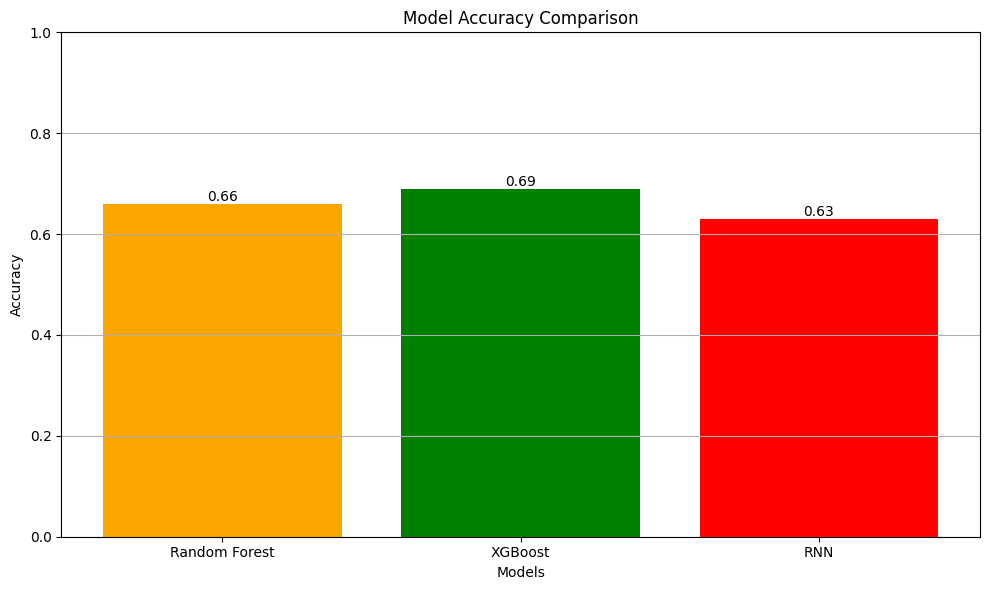

In [78]:
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Accuracy'], color=['orange', 'green', 'red'])
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.grid(axis='y')

for index, value in enumerate(accuracy_scores):
    plt.text(index, value, f"{value:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()